## Ensemble_Learning_with_LogitBoost

In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib. pyplot as plt
import seaborn as sns

from sklearn import metrics

from scipy import stats
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import classification_report, confusion_matrix
from numpy.random import randn

from matplotlib import pyplot
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit


from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LinearRegression
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

from sklearn.preprocessing import KBinsDiscretizer
from collections import defaultdict
from operator import itemgetter

from sklearn.model_selection import GridSearchCV

import sklearn.preprocessing as preproc

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Util methods used in the questions 1 and 2

In [2]:
def get_index(df_param, column_name):
    target_index = df_param.columns.get_loc(column_name)
    return target_index

In [3]:
def get_target_index(df):
    target_name = "death_event"
    target_index = df.columns.get_loc(target_name)
    return target_index

In [4]:
def train_test_feature_split(df_param, target_index):
    train_data = df_param.iloc[train_set_start_index:train_set_end_index, 0:target_index]
    test_data = df_param.iloc[test_set_start_index:test_set_end_index, 0:target_index]
    
    return train_data, test_data

In [5]:
def train_test_label_split(patients_df, target_index):
    train_labels = patients_df.iloc[train_set_start_index:train_set_end_index, target_index:]
    test_lables = patients_df.iloc[test_set_start_index:test_set_end_index, target_index:]
    
    return train_labels, test_lables

In [6]:
def train_val_feature_split(df_param, target_index):
    train_data = df_param.iloc[train_set_start_index:train_set_end_index, 0:target_index]
    test_data = df_param.iloc[test_set_start_index:test_set_end_index, 0:target_index]
    
    return train_data, test_data

### Calculations for the Model Performance Metrics - Matthews correlation coefficient, PR AUC, ROC AUC, TP rate TN rate

In [7]:
def calculate_mcc(tp, fp, tn, fn):
    numerator = (tp*tn) - (fp*fn)
    denom = (tp+fp)*(tp+fn)*(tn+fp)*(tn+fn)
    if denom == 0:
        denom = 1
    mcc = numerator/np.sqrt(denom)
    return mcc

In [8]:
def calculate_roc_auc(y_test, y_pred_pos):
    roc_auc = roc_auc_score(y_test, y_pred_pos)
    return roc_auc

In [9]:
def calculate_pr_auc(y_test, y_pred_pos):
    pr_auc = average_precision_score(y_test, y_pred_pos)
    return pr_auc

In [10]:
def model_metrics(y_test, y_pred, y_pred_proba):

    tn, fp, fn, tp = metrics.confusion_matrix(y_test, y_pred, labels=[0,1]).ravel()
    
    mcc = calculate_mcc(tp, fp, tn, fn)
    f1_score = metrics.f1_score(y_test, y_pred)
    accuracy = metrics.accuracy_score(y_test, y_pred)
    tp_rate = tp/(tp+fn)
    tn_rate = tn/(tn+fp)
    roc_auc = calculate_roc_auc(y_test, y_pred_proba)
    pr_auc = calculate_pr_auc(y_test, y_pred_proba)
    
    return {
            'MCC': mcc, 
            'F1 Score': f1_score, 
            'Accuracy': accuracy, 
            'TP Rate': tp_rate, 
            'TN Rate': tn_rate, 
            'PR AUC': pr_auc, 
            'ROC AUC': roc_auc}

### 1. Read the article and reproduce the results presented in Table-4 using Python modules and packages (including your own script or customised codes). Write a report summarising the dataset, used ML methods, experiment protocol and results including variations, if any. During reproducing the results:

i) you should use the same set of features used by the authors.<br>
ii) you should use the same classifier with exact parameter values.<br>
iii) you should use the same training/test splitting approach as used by the authors.<br>
iv) you should use the same pre/post processing, if any, used by the authors.<br>
v) you should report the same performance metrics as shown in Table-4.<br>

## Loading data

In [11]:
ht_ds_url = "https://raw.githubusercontent.com/pam1202g/SIT720_A5/main/heart_failure_clinical_records_dataset.csv"

In [12]:
df_all = pd.read_csv(ht_ds_url)
print(f"The dimensions of data {df_all.shape}\n")

print(f"datatypes found")
print("---------------------------------------------------")
print(df_all.dtypes)

The dimensions of data (299, 13)

datatypes found
---------------------------------------------------
age                         float64
anaemia                       int64
creatinine_phosphokinase      int64
diabetes                      int64
ejection_fraction             int64
high_blood_pressure           int64
platelets                   float64
serum_creatinine            float64
serum_sodium                  int64
sex                           int64
smoking                       int64
time                          int64
DEATH_EVENT                   int64
dtype: object


In [13]:
df_all.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


### Summary Statistics

In [14]:
df_all.describe().T

,count,mean,std,min,25%,50%,75%,max
age,299.0,60.833893,11.894809,40.0,51.0,60.0,70.0,95.0
anaemia,299.0,0.431438,0.496107,0.0,0.0,0.0,1.0,1.0
creatinine_phosphokinase,299.0,581.839465,970.287881,23.0,116.5,250.0,582.0,7861.0
diabetes,299.0,0.418060,0.494067,0.0,0.0,0.0,1.0,1.0
ejection_fraction,299.0,38.083612,11.834841,14.0,30.0,38.0,45.0,80.0
high_blood_pressure,299.0,0.351171,0.478136,0.0,0.0,0.0,1.0,1.0
platelets,299.0,263358.029264,97804.236869,25100.0,212500.0,262000.0,303500.0,850000.0
serum_creatinine,299.0,1.393880,1.034510,0.5,0.9,1.1,1.4,9.4
serum_sodium,299.0,136.625418,4.412477,113.0,134.0,137.0,140.0,148.0
sex,299.0,0.648829,0.478136,0.0,0.0,1.0,1.0,1.0


### Visualising the distribution of all the numeric features in the dataset

<Figure size 2000x300 with 0 Axes>

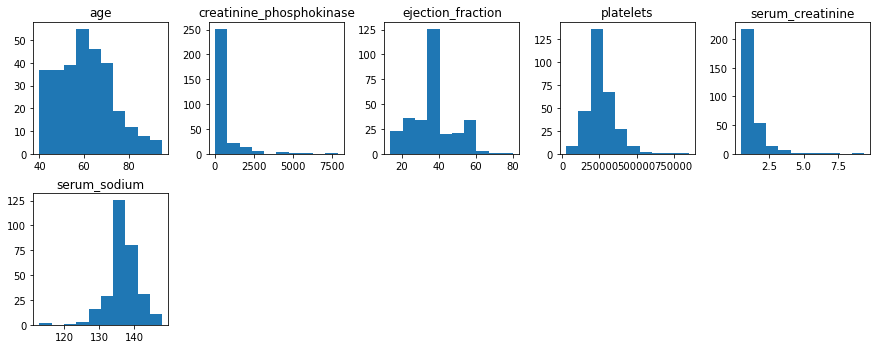

In [15]:
plt.figure(figsize = (20,3), dpi = 100)
df_all.hist(column=['age', 'creatinine_phosphokinase', 'ejection_fraction', 'platelets', 'serum_creatinine', 'serum_sodium'], figsize=(15,15), layout=(5,5), grid=False)
plt.show()

### Univariate Analysis : Categorical Variables

Text(0, 0.5, 'fraction/percent')

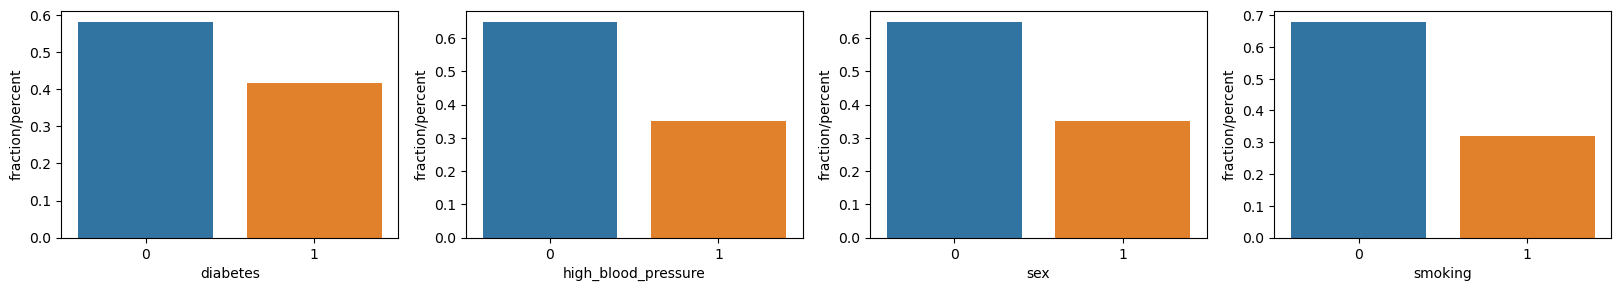

In [16]:
plt.figure(figsize = (20,3), dpi = 100)

count = df_all['diabetes'].value_counts(normalize = True)
unique = df_all['diabetes'].nunique()

plt.subplot(1,4,1)
sns.barplot(count.index, count, order = count.index)
plt.ylabel('fraction/percent', fontsize = 10)
plt.xlabel('{}'.format('diabetes'), fontsize = 10)


count = df_all['high_blood_pressure'].value_counts(normalize = True)
unique = df_all['high_blood_pressure'].nunique()

plt.subplot(1,4,2)
sns.barplot(count.index, count, order = count.index)
plt.ylabel('fraction/percent', fontsize = 10)
plt.xlabel('{}'.format('high_blood_pressure'), fontsize = 10)


count = df_all['high_blood_pressure'].value_counts(normalize = True)
unique = df_all['high_blood_pressure'].nunique()

plt.subplot(1,4,3)
sns.barplot(count.index, count, order = count.index)
plt.xlabel('{}'.format('sex'), fontsize = 10)
plt.ylabel('fraction/percent', fontsize = 10)


count = df_all['smoking'].value_counts(normalize = True)
unique = df_all['smoking'].nunique()

plt.subplot(1,4,4)
sns.barplot(count.index, count, order = count.index)
plt.xlabel('{}'.format('smoking'), fontsize = 10)
plt.ylabel('fraction/percent', fontsize = 10)

## Survival Prediction with all features (except time) without hyperparameter optimization

### Dropping the time column

In [17]:
time_col_index = get_index(df_all, "time")

In [18]:
patients_df = df_all.drop(df_all.columns[time_col_index], axis=1)

In [19]:
patients_df.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,1


### Changing the target column name to lowercase (for consistency)

In [20]:
patients_df = patients_df.rename(columns={'DEATH_EVENT':'death_event'})
patients_df.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,death_event
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,1


### Split dataset to 80/20 percentages for training/testing Models 'without' Hyperparameter optimization and setting the Start and End indexes of these splits 

In [21]:
iteration_num = 100
train_set_perc = 80

train_set_start_index = 0
train_set_end_index = int(np.round(patients_df.shape[0]*(train_set_perc/100)))

test_set_start_index = train_set_end_index
test_set_end_index = patients_df.shape[0]

target_name = "death_event"
target_index = patients_df.columns.get_loc(target_name)
list_metrics = []

### Dataset imbalance ratio 


 Number of Survived patients = 67.89 %

 Number of Dead patients     = 32.11 %



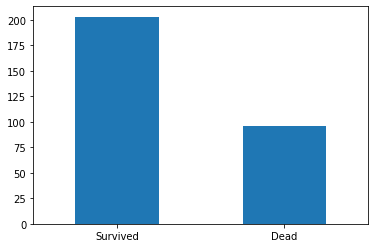

In [22]:
def imbalance_retriever(df_param):
    imb_count = df_param['death_event'].value_counts()
    print("\n Number of Survived patients =", 
          np.round((imb_count[0]/(imb_count[0] + imb_count[1])) * 100, decimals=2), "%")
    print("\n Number of Dead patients     =", 
          np.round((imb_count[1]/(imb_count[0] + imb_count[1])) * 100, decimals=2),"%\n")
    
    imb_count.plot(kind='bar')
    plt.xticks([0, 1], ['Survived', 'Dead'], rotation=0)
    plt.show()

imbalance_retriever(patients_df)

### Number of Executions to study the performance and calculate Mean of the metrics = 100

In [23]:
number_of_executions = 100

### Aggregating the metrices of all the 100 iterations using Mean

In [24]:
def aggregate_metrics(metrics_param_df, model_name, list_metrics):
    dict_metrics = {'Method': model_name,
            'MCC': metrics_param_df["MCC"].mean(), 
            'F1 Score': metrics_param_df["F1 Score"].mean(), 
            'Accuracy': metrics_param_df["Accuracy"].mean(), 
            'TP Rate': metrics_param_df["TP Rate"].mean(), 
            'TN Rate': metrics_param_df["TN Rate"].mean(), 
            'PR AUC': metrics_param_df["PR AUC"].mean(), 
            'ROC AUC': metrics_param_df["ROC AUC"].mean()
    }
    list_metrics.append(dict_metrics)
    mean_df = pd.DataFrame(data=list_metrics, columns=["Method", "MCC","F1 Score","Accuracy","TP Rate","TN Rate","PR AUC","ROC AUC"])

    return mean_df  

### Common method for Training Models 'without' Hyperparameter Optimizations & and Collecting their Metrics - MCC, F1 Score, Accuracy, TP Rate, TN Rate, PR AUC, and ROC AUC

In [25]:
def get_metrics_for_models_without_hyperparam_optimization(model, target_index, p_df):
    metric_records = []
    reproducible_counter = 200
    record_count = p_df.shape[0]
    
    for i in range(number_of_executions):
        patients_df_rnd = p_df.sample(n=record_count, random_state=reproducible_counter)
        reproducible_counter -= 1
        target_label = patients_df_rnd.columns[target_index]
        
        X_train, X_test = train_test_feature_split(patients_df_rnd, target_index)
        y_train, y_test = train_test_label_split(patients_df_rnd, target_index)

        model.fit(X_train,y_train.values.ravel())
        

        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)
        model_probs = y_pred_proba[:, 1]

        metric = model_metrics(y_test, y_pred, model_probs)
        metric_records.append(metric)
        
    model_metrics_df = pd.DataFrame(columns=["MCC","F1 Score","Accuracy","TP Rate","TN Rate","PR AUC","ROC AUC"], 
                                    data=metric_records)
    return model_metrics_df

### 
### Random Forest Classifier 
### -------------------------------------
### Applied all the hyperparameters that are 'default values' in the R library in order to bring this scikit-learn based implementation at par with the R implementation and keep the implementation consistent with the Research Article (Source Page 17 of https://cran.r-project.org/web/packages/randomForest/randomForest.pdf) 

In [26]:
rfclf = RandomForestClassifier(n_estimators=500, bootstrap=True, oob_score=True, random_state=11)
rf_metrics_df = get_metrics_for_models_without_hyperparam_optimization(rfclf, target_index, patients_df)

aggr_metric_df = aggregate_metrics(rf_metrics_df, "Random forest", list_metrics)
aggr_metric_df.head(10)

,Method,MCC,F1 Score,Accuracy,TP Rate,TN Rate,PR AUC,ROC AUC
0,Random forest,0.38956,0.549224,0.745167,0.502337,0.861123,0.640294,0.787971


### 
### Decision Tree Classifier
### -------------------------------------
### Applied all the hyperparameters that are 'default values' in the R library in order to bring this scikit-learn based implementation at par with the R implementation and keep the implementation consistent with the Research Article (Source: https://www.rdocumentation.org/packages/rpart/versions/4.1-15/topics/rpart.control)
rpart.control(minsplit = 20, minbucket = round(minsplit/3), cp = 0.01, maxcompete = 4, maxsurrogate = 5, usesurrogate = 2, xval = 10, surrogatestyle = 0, maxdepth = 30, …) <br>
In scikit-learn implementation 'min_samples_leaf' is equivalent to 'minbucket' and hence would have a rounded value of 7  

In [27]:
dec_clf = DecisionTreeClassifier(max_depth=30, min_samples_split=20, min_samples_leaf=7, random_state=42)
dt_metrics_df = get_metrics_for_models_without_hyperparam_optimization(dec_clf, target_index, patients_df)

aggr_metric_df = aggregate_metrics(dt_metrics_df, "Decision tree", list_metrics)
aggr_metric_df.head(10)

,Method,MCC,F1 Score,Accuracy,TP Rate,TN Rate,PR AUC,ROC AUC
0,Random forest,0.389560,0.549224,0.745167,0.502337,0.861123,0.640294,0.787971
1,Decision tree,0.361893,0.540196,0.730833,0.511400,0.834115,0.557652,0.737026


###  
### Naive Bayes Classifier
### -------------------------------------

In [28]:
nb_clf = GaussianNB()
nb_metrics_df = get_metrics_for_models_without_hyperparam_optimization(nb_clf, target_index, patients_df)

aggr_metric_df = aggregate_metrics(nb_metrics_df, "Naive Bayes", list_metrics)
aggr_metric_df.head(10)

,Method,MCC,F1 Score,Accuracy,TP Rate,TN Rate,PR AUC,ROC AUC
0,Random forest,0.389560,0.549224,0.745167,0.502337,0.861123,0.640294,0.787971
1,Decision tree,0.361893,0.540196,0.730833,0.511400,0.834115,0.557652,0.737026
2,Naive Bayes,0.218948,0.312459,0.704833,0.217655,0.932681,0.574555,0.729178


###  
### XGBoost Classifier
### ----------------------------
### Applied all the hyperparameters obtained from the source code in the  Github Repository referenced in the Research Article: 'max_depth=2' and 'learning_rate=1'. (Source https://github.com/davidechicco/cardiovascular_heart_disease/blob/master/bin/xgboost_classification.r)

#### Installing XGBoost library 

In [29]:
!pip install xgboost

In [30]:
import xgboost as xgb

In [31]:
xgb_clf = xgb.XGBClassifier(random_state=10, 
                            max_depth=2, 
                            learning_rate=1, use_label_encoder=False, eval_metric="logloss")
xgb_metrics_df = get_metrics_for_models_without_hyperparam_optimization(xgb_clf, target_index, patients_df)

aggr_metric_df = aggregate_metrics(xgb_metrics_df, "Gradient boosting", list_metrics)
aggr_metric_df.head(10)

,Method,MCC,F1 Score,Accuracy,TP Rate,TN Rate,PR AUC,ROC AUC
0,Random forest,0.389560,0.549224,0.745167,0.502337,0.861123,0.640294,0.787971
1,Decision tree,0.361893,0.540196,0.730833,0.511400,0.834115,0.557652,0.737026
2,Naive Bayes,0.218948,0.312459,0.704833,0.217655,0.932681,0.574555,0.729178
3,Gradient boosting,0.280042,0.493291,0.691500,0.483670,0.790102,0.544580,0.690555


###  
### One Rule Classifier
### ----------------------------

#### Installing OneRClassifier library

In [32]:
!pip install mlxtend

In [33]:
from mlxtend.classifier import OneRClassifier

#### Data Preprocessing is required to discretize all the continuous numerical features

In [34]:
patients_df_cont = patients_df[["age","creatinine_phosphokinase", "ejection_fraction", "platelets", "serum_creatinine","serum_sodium"]]
kbins = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform')
pat_cont_vals = kbins.fit_transform(patients_df_cont)
patients_df_cat = patients_df[["anaemia","diabetes","high_blood_pressure","sex","smoking","death_event"]]
pat_cat_vals = patients_df_cat.values

disc_arr = np.concatenate((pat_cont_vals,pat_cat_vals),axis=1)
df_trans_int = disc_arr.astype('int32')
df_oner = pd.DataFrame(data=df_trans_int)

In [35]:
def get_metrics_for_onerule_without_hyperparam_optimization(target_index, p_df):
    metric_records = []
    reproducible_counter = 200
    record_count = p_df.shape[0]
    
    for i in range(number_of_executions):
        patients_df_rnd = p_df.sample(n=record_count, random_state=reproducible_counter)
        reproducible_counter -= 1
        target_label = patients_df_rnd.columns[target_index]
        
        patients_np_rnd = patients_df_rnd.to_numpy() 
    
        X = patients_np_rnd[0:record_count, 0:target_index]
        y = patients_np_rnd[0:record_count, target_index:]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)
        
        oner_m = OneRClassifier()
        oner_m.fit(X_train, y_train.flatten())
        y_pred = oner_m.predict(X_test)

        metric = model_metrics(y_test, y_pred, y_pred)
        metric_records.append(metric)
        
    model_metrics_df = pd.DataFrame(columns=["MCC","F1 Score","Accuracy","TP Rate","TN Rate","PR AUC","ROC AUC"], 
                                    data=metric_records)
    return model_metrics_df

In [36]:
or_metrics_df = get_metrics_for_onerule_without_hyperparam_optimization(target_index, df_oner)

aggr_metric_df = aggregate_metrics(or_metrics_df, "One rule", list_metrics)
aggr_metric_df.head()

,Method,MCC,F1 Score,Accuracy,TP Rate,TN Rate,PR AUC,ROC AUC
0,Random forest,0.389560,0.549224,0.745167,0.502337,0.861123,0.640294,0.787971
1,Decision tree,0.361893,0.540196,0.730833,0.511400,0.834115,0.557652,0.737026
2,Naive Bayes,0.218948,0.312459,0.704833,0.217655,0.932681,0.574555,0.729178
3,Gradient boosting,0.280042,0.493291,0.691500,0.483670,0.790102,0.544580,0.690555
4,One rule,0.342119,0.483513,0.738167,0.394211,0.897561,0.451025,0.645886


### 
### Linear Regression Classifier
### -----------------------------------------
### Used 0.5 as the 'Threshold' for the purpose of Binary Classification. This usage is based on the sourcecode in Github Repository referenced in the Research Article (Source https://github.com/davidechicco/cardiovascular_heart_disease/blob/master/bin/lin_reg_classification.r)

In [37]:
def get_metrics_for_linear_reg_without_hyperparam_optimization(model, target_index, p_df):
    metric_records = []
    reproducible_counter = 200
    record_count = p_df.shape[0]
    
    threshold = 0.5 # based on R-code referenced from the Research Article 
    
    
    for i in range(number_of_executions):
        patients_df_rnd = p_df.sample(n=record_count, random_state=reproducible_counter)
        reproducible_counter -= 1
        target_label = patients_df_rnd.columns[target_index]
        
        X_train, X_test = train_test_feature_split(patients_df_rnd, target_index)
        y_train, y_test = train_test_label_split(patients_df_rnd, target_index)

        model.fit(X_train,y_train.values.ravel())

        y_pred_lr = model.predict(X_test)
        
        all_scores = len(y_pred_lr)
        for score_index in range(all_scores):
            score = y_pred_lr[score_index]
            if score >= threshold:
                y_pred_lr[score_index] = 1
            else:
                y_pred_lr[score_index] = 0
            
        
        metric = model_metrics(y_test, y_pred_lr, y_pred_lr)
        metric_records.append(metric)
        
    
    model_metrics_df = pd.DataFrame(columns=["MCC","F1 Score","Accuracy","TP Rate","TN Rate","PR AUC","ROC AUC"], 
                                    data=metric_records)
    return model_metrics_df

In [38]:
lr_clf = LinearRegression()
lr_metrics_df = get_metrics_for_linear_reg_without_hyperparam_optimization(lr_clf, target_index, patients_df)

aggr_metric_df = aggregate_metrics(lr_metrics_df, "Linear Regression", list_metrics)
aggr_metric_df.head(10)

,Method,MCC,F1 Score,Accuracy,TP Rate,TN Rate,PR AUC,ROC AUC
0,Random forest,0.389560,0.549224,0.745167,0.502337,0.861123,0.640294,0.787971
1,Decision tree,0.361893,0.540196,0.730833,0.511400,0.834115,0.557652,0.737026
2,Naive Bayes,0.218948,0.312459,0.704833,0.217655,0.932681,0.574555,0.729178
3,Gradient boosting,0.280042,0.493291,0.691500,0.483670,0.790102,0.544580,0.690555
4,One rule,0.342119,0.483513,0.738167,0.394211,0.897561,0.451025,0.645886
5,Linear Regression,0.345312,0.485780,0.736167,0.404268,0.893314,0.456069,0.648791


###  
### Artificial neural network Classifier
### -------------------------------------------------
### 1. There is 'no' code included for Artificial neural network in the Github Repository for the referenced in the Research Article. There is only an older version of a Lua code that has a Torch implementation using a different dataset. 
### 2. This older version of code mentioned is using a 'Normalized' version of the dataset 'dataset_edited_without_time_NORM.csv'. So, to keep the implementation consistent a 'StandardScaler' from scikit-learn library has been used.  (Source https://github.com/davidechicco/cardiovascular_heart_disease/blob/master/bin_previous/ann_script_val.lua)
### 3. The Hyperparameter 'hidden_layer_sizes=100' is based on the information collected from Table 4 - Caption of the Research Article.

In [39]:
def mlp_without_hyperparam_optimization(target_index, p_df, model):
    metric_records = []
    reproducible_counter = 200
    record_count = p_df.shape[0]
    
    for i in range(number_of_executions):
        patients_df_rnd = p_df.sample(n=record_count, random_state=reproducible_counter)
        reproducible_counter -= 1
        target_label = patients_df_rnd.columns[target_index]
        
        X_train, X_test = train_test_feature_split(patients_df_rnd, target_index)
        y_train, y_test = train_test_label_split(patients_df_rnd, target_index)
        
        scaler = preproc.StandardScaler()
        scaler.fit(X_train)
        X_train = scaler.transform(X_train)
        
        X_test = scaler.transform(X_test)

        model.fit(X_train,y_train.values.ravel())
        

        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)
        model_probs = y_pred_proba[:, 1]

        metric = model_metrics(y_test, y_pred, model_probs)
        metric_records.append(metric)
        
    model_metrics_df = pd.DataFrame(columns=["MCC","F1 Score","Accuracy","TP Rate","TN Rate","PR AUC","ROC AUC"], 
                                    data=metric_records)
    
    return model_metrics_df

In [40]:
mlp_clf = MLPClassifier(max_iter=2000, hidden_layer_sizes=100, random_state=10)
mlp_metrics_df = mlp_without_hyperparam_optimization(target_index, patients_df, mlp_clf)

aggr_metric_df = aggregate_metrics(mlp_metrics_df, "Artificial neural network", list_metrics)
aggr_metric_df.head(10)

,Method,MCC,F1 Score,Accuracy,TP Rate,TN Rate,PR AUC,ROC AUC
0,Random forest,0.389560,0.549224,0.745167,0.502337,0.861123,0.640294,0.787971
1,Decision tree,0.361893,0.540196,0.730833,0.511400,0.834115,0.557652,0.737026
2,Naive Bayes,0.218948,0.312459,0.704833,0.217655,0.932681,0.574555,0.729178
3,Gradient boosting,0.280042,0.493291,0.691500,0.483670,0.790102,0.544580,0.690555
4,One rule,0.342119,0.483513,0.738167,0.394211,0.897561,0.451025,0.645886
5,Linear Regression,0.345312,0.485780,0.736167,0.404268,0.893314,0.456069,0.648791
6,Artificial neural network,0.318454,0.524045,0.705667,0.521753,0.793077,0.530888,0.693950


##  
## Survival Prediction with all features (except time) with hyperparameter optimization

In [41]:
training_set_perce = 60
validation_set_perce = 20
test_set_perce = 100 - training_set_perce - validation_set_perce

training_subset_start_idx = 0
record_count = patients_df.shape[0]
training_subset_end_idx = int(np.round(record_count*(training_set_perce/100)))
print("Training subset end index ", training_subset_end_idx)

val_subset_start_idx = training_subset_end_idx
val_subset_end_idx = int(np.round(record_count*(training_set_perce + validation_set_perce)/100))
print("Validation subset start index ", val_subset_start_idx)
print("Validation subset end index ", val_subset_end_idx)

Training subset end index  179
Validation subset start index  179
Validation subset end index  239


###  
### SVM radial Classifier
### ------------------------------
### 1. The hyperparameter values for 'C' (0.001, 0.01, 0.1, 1, 10) have been obtained from the source code in the  Github Repository referenced in the Research Article.
### 2. The R library performs 'Normalization by default' for SVM algorithm. This behaviour has been replicated in the following code using StandardScaler available in scikit-learn to keep the implementation consistent with the Research Article. <br>(Source: Page 6 of the library manual https://cran.r-project.org/web/packages/e1071/vignettes/svmdoc.pdf)

In [42]:
def svm_radial_with_hyperparam_optimization(target_index, p_df):
    metric_records = []
    reproducible_counter = 200
    record_count = p_df.shape[0]
    
    for i in range(number_of_executions):
        rnd_patients_df = p_df.sample(n=record_count, random_state=reproducible_counter)
        reproducible_counter -= 1
        
        X_train, X_test = train_test_feature_split(rnd_patients_df, target_index)
        y_train, y_test = train_test_label_split(rnd_patients_df, target_index)
        
        c_hyp = [0.001, 0.01, 0.1, 1, 10]
        
        
        best_c_param = 0
        mcc_dict = {}
        
        for c_param in c_hyp:    
            X_trn_sub = rnd_patients_df.iloc[training_subset_start_idx:training_subset_end_idx, 
                                                        0:target_index]
            y_trn_sub = rnd_patients_df.iloc[training_subset_start_idx:training_subset_end_idx, 
                                                        target_index:]
            X_val = rnd_patients_df.iloc[val_subset_start_idx:val_subset_end_idx, 0:target_index]
            y_val = rnd_patients_df.iloc[val_subset_start_idx:val_subset_end_idx, target_index:]
            
            scaler = preproc.StandardScaler()
            scaler.fit(X_trn_sub)
            X_trn_sub = scaler.transform(X_trn_sub)

            X_val = scaler.transform(X_val)
            
            svm_rbf_hyp= svm.SVC(kernel="rbf", C=c_param)
            svm_rbf_hyp.fit(X_trn_sub, y_trn_sub.values.ravel())
            y_val_pred_svm = svm_rbf_hyp.predict(X_val)
            
            htn, hfp, hfn, htp = confusion_matrix(y_val, y_val_pred_svm, labels=[0,1]).ravel()
            mcc_key = calculate_mcc(htp, hfp, htn, hfn)
            mcc_dict[mcc_key] = c_param
        
        sorted_by_mcc = sorted(mcc_dict.keys(), reverse=True)
        best_mcc_score = sorted_by_mcc[0]
        best_c_param = mcc_dict[best_mcc_score]

        
        scaler = preproc.StandardScaler()
        scaler.fit(X_train)
        X_train = scaler.transform(X_train)
        X_test = scaler.transform(X_test)
    
        svm_radial= svm.SVC(kernel="rbf", C=best_c_param)
        svm_radial.fit(X_train, y_train.values.ravel())
        y_pred_svm = svm_radial.predict(X_test)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred_svm, labels=[0,1]).ravel()
        mcc = calculate_mcc(tp, fp, tn, fn)

        metric = model_metrics(y_test, y_pred_svm, y_pred_svm)
        metric_records.append(metric)
        
    model_metrics_df = pd.DataFrame(columns=["MCC","F1 Score","Accuracy","TP Rate","TN Rate","PR AUC","ROC AUC"], 
                                    data=metric_records)
    return model_metrics_df

In [43]:
svm_rbf_metrics_df = svm_radial_with_hyperparam_optimization(target_index, patients_df)

aggr_metric_df = aggregate_metrics(svm_rbf_metrics_df, "SVM radial", list_metrics)
aggr_metric_df.head(10)

,Method,MCC,F1 Score,Accuracy,TP Rate,TN Rate,PR AUC,ROC AUC
0,Random forest,0.389560,0.549224,0.745167,0.502337,0.861123,0.640294,0.787971
1,Decision tree,0.361893,0.540196,0.730833,0.511400,0.834115,0.557652,0.737026
2,Naive Bayes,0.218948,0.312459,0.704833,0.217655,0.932681,0.574555,0.729178
3,Gradient boosting,0.280042,0.493291,0.691500,0.483670,0.790102,0.544580,0.690555
4,One rule,0.342119,0.483513,0.738167,0.394211,0.897561,0.451025,0.645886
5,Linear Regression,0.345312,0.485780,0.736167,0.404268,0.893314,0.456069,0.648791
6,Artificial neural network,0.318454,0.524045,0.705667,0.521753,0.793077,0.530888,0.693950
7,SVM radial,0.324521,0.502552,0.719167,0.460085,0.841230,0.443658,0.650657


###  
### SVM linear Classifier
### ------------------------------
### 1. The hyperparameter values for 'C' (0.001, 0.01, 0.1, 1, 10) have been obtained from the source code in the  Github Repository referenced in the Research Article
### 2. The R library performs 'Normalization by default' for SVM algorithm. This behaviour has been replicated in the following code using StandardScaler available in scikit-learn to keep the implementation consistent with the Research Article. <br>(Source: Page 6 of the library manual https://cran.r-project.org/web/packages/e1071/vignettes/svmdoc.pdf)

In [44]:
def svm_linear_with_hyperparam_optimization(target_index, p_df):
    metric_records = []
    reproducible_counter = 200
    record_count = p_df.shape[0]
    
    for i in range(number_of_executions):
        rnd_patients_df = p_df.sample(n=record_count, random_state=reproducible_counter)
        reproducible_counter -= 1
        
        X_train, X_test = train_test_feature_split(rnd_patients_df, target_index)
        y_train, y_test = train_test_label_split(rnd_patients_df, target_index)
        
        c_hyp = [0.001, 0.01, 0.1, 1, 10]
        
        
        best_c_param = 0
        mcc_dict = {}
        
        for c_param in c_hyp:    
            X_trn_sub = rnd_patients_df.iloc[training_subset_start_idx:training_subset_end_idx, 
                                                        0:target_index]
            y_trn_sub = rnd_patients_df.iloc[training_subset_start_idx:training_subset_end_idx, 
                                                        target_index:]
            X_val = rnd_patients_df.iloc[val_subset_start_idx:val_subset_end_idx, 0:target_index]
            y_val = rnd_patients_df.iloc[val_subset_start_idx:val_subset_end_idx, target_index:]
            
            scaler = preproc.StandardScaler()
            scaler.fit(X_trn_sub)
            X_trn_sub = scaler.transform(X_trn_sub)

            X_val = scaler.transform(X_val)
            
            svm_lnr_hyp= svm.SVC(kernel="linear", C=c_param)
            svm_lnr_hyp.fit(X_trn_sub, y_trn_sub.values.ravel())
            y_val_pred_svm = svm_lnr_hyp.predict(X_val)
            
            htn, hfp, hfn, htp = confusion_matrix(y_val, y_val_pred_svm, labels=[0,1]).ravel()
            mcc_key = calculate_mcc(htp, hfp, htn, hfn)
            mcc_dict[mcc_key] = c_param
        
        sorted_by_mcc = sorted(mcc_dict.keys(), reverse=True)
        best_mcc_score = sorted_by_mcc[0]
        best_c_param = mcc_dict[best_mcc_score]

        
        scaler = preproc.StandardScaler()
        scaler.fit(X_train)
        X_train = scaler.transform(X_train)
        X_test = scaler.transform(X_test)
    
        svm_linear= svm.SVC(kernel="linear", C=best_c_param)
        svm_linear.fit(X_train, y_train.values.ravel())
        y_pred_svm = svm_linear.predict(X_test)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred_svm, labels=[0,1]).ravel()
        mcc = calculate_mcc(tp, fp, tn, fn)

        metric = model_metrics(y_test, y_pred_svm, y_pred_svm)
        metric_records.append(metric)
        
    model_metrics_df = pd.DataFrame(columns=["MCC","F1 Score","Accuracy","TP Rate","TN Rate","PR AUC","ROC AUC"], 
                                    data=metric_records)
    return model_metrics_df

In [45]:
svm_lnr_metrics_df = svm_linear_with_hyperparam_optimization(target_index, patients_df)

aggr_metric_df = aggregate_metrics(svm_lnr_metrics_df, "SVM linear", list_metrics)
aggr_metric_df.head(10)

,Method,MCC,F1 Score,Accuracy,TP Rate,TN Rate,PR AUC,ROC AUC
0,Random forest,0.389560,0.549224,0.745167,0.502337,0.861123,0.640294,0.787971
1,Decision tree,0.361893,0.540196,0.730833,0.511400,0.834115,0.557652,0.737026
2,Naive Bayes,0.218948,0.312459,0.704833,0.217655,0.932681,0.574555,0.729178
3,Gradient boosting,0.280042,0.493291,0.691500,0.483670,0.790102,0.544580,0.690555
4,One rule,0.342119,0.483513,0.738167,0.394211,0.897561,0.451025,0.645886
5,Linear Regression,0.345312,0.485780,0.736167,0.404268,0.893314,0.456069,0.648791
6,Artificial neural network,0.318454,0.524045,0.705667,0.521753,0.793077,0.530888,0.693950
7,SVM radial,0.324521,0.502552,0.719167,0.460085,0.841230,0.443658,0.650657
8,SVM linear,0.341615,0.480952,0.736000,0.410760,0.889765,0.454959,0.650263


###  
### k-Nearest Neighbors Classifier
### --------------------------------------------
### 1. The range of hyperparameter values for n_neighbors from 1 to 100 has been obtained from the source code in the  Github Repository referenced in the Research Article
### 2. The R library performs 'Normalization by default' for k-NN algorithm. This behaviour has been replicated in the following code using StandardScaler available in scikit-learn to keep the implementation consistent with the Research Article. <br>(Source: https://www.rdocumentation.org/packages/DMwR/versions/0.4.1/topics/kNN)

kNN(form, train, test, norm = T, norm.stats = NULL, ...)<br>
norm - A boolean indicating whether the training data should be previously normalized before obtaining the k-NN predictions (defaults to TRUE). 

In [46]:
def knn_with_hyperparam_optimization(target_index, p_df):
    metric_records = []
    reproducible_counter = 200
    record_count = p_df.shape[0]
    
    for i in range(number_of_executions):
        rnd_patients_df = p_df.sample(n=record_count, random_state=reproducible_counter)
        reproducible_counter -= 1
        
        X_train, X_test = train_test_feature_split(rnd_patients_df, target_index)
        y_train, y_test = train_test_label_split(rnd_patients_df, target_index)
        
        best_k = 0
        mcc_dict = {}
        max_K = 100
        
        for k in range(1, max_K):    
            X_trn_sub = rnd_patients_df.iloc[training_subset_start_idx:training_subset_end_idx, 
                                                        0:target_index]
            y_trn_sub = rnd_patients_df.iloc[training_subset_start_idx:training_subset_end_idx, 
                                                        target_index:]
            X_val = rnd_patients_df.iloc[val_subset_start_idx:val_subset_end_idx, 0:target_index]
            y_val = rnd_patients_df.iloc[val_subset_start_idx:val_subset_end_idx, target_index:]
            
            scaler = preproc.StandardScaler()
            scaler.fit(X_trn_sub)
            X_trn_sub = scaler.transform(X_trn_sub)

            X_val = scaler.transform(X_val)
            
            knn_hyp = KNeighborsClassifier(n_neighbors=k)
            knn_hyp.fit(X_trn_sub, y_trn_sub.values.ravel())
            y_val_pred_knn = knn_hyp.predict(X_val)
            
            htn, hfp, hfn, htp = confusion_matrix(y_val, y_val_pred_knn, labels=[0,1]).ravel()
            mcc_key = calculate_mcc(htp, hfp, htn, hfn)
            mcc_dict[mcc_key] = k
        
        sorted_by_mcc = sorted(mcc_dict.keys(), reverse=True)
        best_mcc_score = sorted_by_mcc[0]
        best_k = mcc_dict[best_mcc_score]

        
        scaler = preproc.StandardScaler()
        scaler.fit(X_train)
        X_train = scaler.transform(X_train)
        X_test = scaler.transform(X_test)
    
        knn = KNeighborsClassifier(n_neighbors=best_k)
        knn.fit(X_train, y_train.values.ravel())
        y_pred_knn = knn.predict(X_test)
        y_pred_proba = knn.predict_proba(X_test)
        model_probs = y_pred_proba[:, 1]
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred_knn, labels=[0,1]).ravel()
        mcc = calculate_mcc(tp, fp, tn, fn)

        metric = model_metrics(y_test, y_pred_knn, model_probs)
        metric_records.append(metric)
        
    model_metrics_df = pd.DataFrame(columns=["MCC","F1 Score","Accuracy","TP Rate","TN Rate","PR AUC","ROC AUC"], 
                                    data=metric_records)
    return model_metrics_df

In [47]:
knn_metrics_df = knn_with_hyperparam_optimization(target_index, patients_df)

aggr_metric_df = aggregate_metrics(knn_metrics_df, "k-Nearest Neighbors", list_metrics)
aggr_metric_df.head(10)

,Method,MCC,F1 Score,Accuracy,TP Rate,TN Rate,PR AUC,ROC AUC
0,Random forest,0.389560,0.549224,0.745167,0.502337,0.861123,0.640294,0.787971
1,Decision tree,0.361893,0.540196,0.730833,0.511400,0.834115,0.557652,0.737026
2,Naive Bayes,0.218948,0.312459,0.704833,0.217655,0.932681,0.574555,0.729178
3,Gradient boosting,0.280042,0.493291,0.691500,0.483670,0.790102,0.544580,0.690555
4,One rule,0.342119,0.483513,0.738167,0.394211,0.897561,0.451025,0.645886
5,Linear Regression,0.345312,0.485780,0.736167,0.404268,0.893314,0.456069,0.648791
6,Artificial neural network,0.318454,0.524045,0.705667,0.521753,0.793077,0.530888,0.693950
7,SVM radial,0.324521,0.502552,0.719167,0.460085,0.841230,0.443658,0.650657
8,SVM linear,0.341615,0.480952,0.736000,0.410760,0.889765,0.454959,0.650263
9,k-Nearest Neighbors,0.133726,0.216544,0.684167,0.150226,0.933093,0.487174,0.684778


In [48]:
aggr_metric_df.sort_values(by='MCC', ascending=False).head(10)

,Method,MCC,F1 Score,Accuracy,TP Rate,TN Rate,PR AUC,ROC AUC
0,Random forest,0.389560,0.549224,0.745167,0.502337,0.861123,0.640294,0.787971
1,Decision tree,0.361893,0.540196,0.730833,0.511400,0.834115,0.557652,0.737026
5,Linear Regression,0.345312,0.485780,0.736167,0.404268,0.893314,0.456069,0.648791
4,One rule,0.342119,0.483513,0.738167,0.394211,0.897561,0.451025,0.645886
8,SVM linear,0.341615,0.480952,0.736000,0.410760,0.889765,0.454959,0.650263
7,SVM radial,0.324521,0.502552,0.719167,0.460085,0.841230,0.443658,0.650657
6,Artificial neural network,0.318454,0.524045,0.705667,0.521753,0.793077,0.530888,0.693950
3,Gradient boosting,0.280042,0.493291,0.691500,0.483670,0.790102,0.544580,0.690555
2,Naive Bayes,0.218948,0.312459,0.704833,0.217655,0.932681,0.574555,0.729178
9,k-Nearest Neighbors,0.133726,0.216544,0.684167,0.150226,0.933093,0.487174,0.684778


# Loading dataset

In [49]:
ds_url = "https://raw.githubusercontent.com/pam1202g/SIT720_A5/main/heart_failure_clinical_records_dataset.csv"

In [50]:
df_all = pd.read_csv(ds_url)
print(f"The dimensions of data {df_all.shape}\n")

print(f"datatypes found")
print("---------------------------------------------------")
print(df_all.dtypes)

The dimensions of data (299, 13)

datatypes found
---------------------------------------------------
age                         float64
anaemia                       int64
creatinine_phosphokinase      int64
diabetes                      int64
ejection_fraction             int64
high_blood_pressure           int64
platelets                   float64
serum_creatinine            float64
serum_sodium                  int64
sex                           int64
smoking                       int64
time                          int64
DEATH_EVENT                   int64
dtype: object


### Datatype conversion for Age (float to int) and renaming the column name to lower case for consistency

In [51]:
df_all['age'] = df_all['age'].astype(int)
display(df_all.dtypes)

df_all = df_all.rename(columns={'DEATH_EVENT':'death_event'})
df_all.head()

age                           int64
anaemia                       int64
creatinine_phosphokinase      int64
diabetes                      int64
ejection_fraction             int64
high_blood_pressure           int64
platelets                   float64
serum_creatinine            float64
serum_sodium                  int64
sex                           int64
smoking                       int64
time                          int64
DEATH_EVENT                   int64
dtype: object

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,death_event
0,75,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


# Feature Selection

In [52]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score

In [53]:
feat_sel_df = df_all.copy()

### Splitting the Independent and dependent variables

In [54]:
target_name = "death_event"
target_index = feat_sel_df.columns.get_loc(target_name)

features_df = feat_sel_df.iloc[:,0:target_index]
labels_df = feat_sel_df.iloc[:,target_index:]

In [55]:
predictors = ["age","anaemia","creatinine_phosphokinase","diabetes","ejection_fraction","high_blood_pressure","platelets","serum_creatinine","serum_sodium","sex","smoking","time"]

### Apply preprocessing - standard scaling

In [56]:
from sklearn.preprocessing import StandardScaler

def apply_standard_scaling(feat_df):
    scaler = StandardScaler()  
    scaler.fit(feat_df)  
    scaled_X = scaler.transform(feat_df)  
    return scaled_X

def apply_standard_scaling_to_train_test(train_feat_df, test_feat_df):
    scaler = StandardScaler()  
    scaler.fit(train_feat_df)  
    X_train = scaler.transform(train_feat_df)  
    X_test = scaler.transform(test_feat_df)
    return X_train, X_test

In [57]:
scaled_data = apply_standard_scaling(features_df)

predictors_df = pd.DataFrame(data=scaled_data, columns=["age","anaemia","creatinine_phosphokinase","diabetes","ejection_fraction","high_blood_pressure","platelets","serum_creatinine","serum_sodium","sex","smoking","time"])
predictors_df.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time
0,1.193302,-0.871105,0.000166,-0.847579,-1.530560,1.359272,1.681648e-02,0.490057,-1.504036,0.735688,-0.687682,-1.629502
1,-0.490896,-0.871105,7.514640,-0.847579,-0.007077,-0.735688,7.535660e-09,-0.284552,-0.141976,0.735688,-0.687682,-1.603691
2,0.351203,-0.871105,-0.449939,-0.847579,-1.530560,-0.735688,-1.038073e+00,-0.090900,-1.731046,0.735688,1.454161,-1.590785
3,-0.911945,1.147968,-0.486071,-0.847579,-1.530560,-0.735688,-5.464741e-01,0.490057,0.085034,0.735688,-0.687682,-1.590785
4,0.351203,1.147968,-0.435486,1.179830,-1.530560,-0.735688,6.517986e-01,1.264666,-4.682176,-1.359272,-0.687682,-1.577879


In [58]:
print('No. of Predictors = {}'.format(predictors_df.shape[1]))

No. of Predictors = 12


### Feature selection from coefficients - using LassoCV

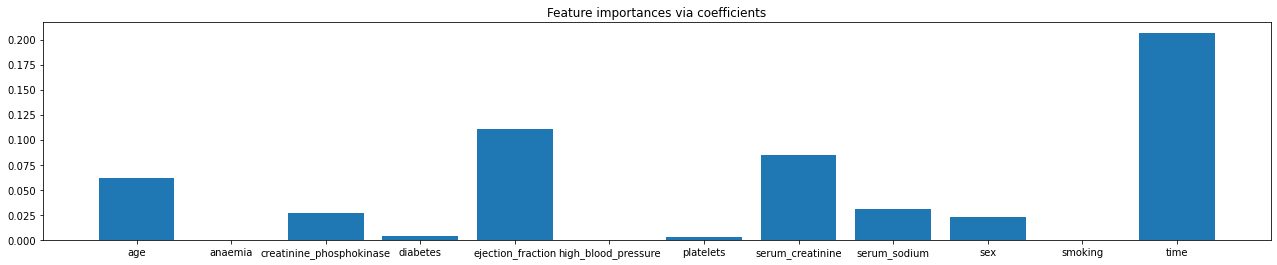

In [59]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LassoCV

lasso = LassoCV().fit(predictors_df, labels_df.values.flatten())
importance = np.abs(lasso.coef_)

plt.figure(figsize=(22,4))
plt.bar(height=importance, x=predictors)
plt.title("Feature importances via coefficients")
plt.show()

In [60]:
df_lcv = pd.DataFrame(data=[importance], columns=[predictors])
df_lcv_T = df_lcv.T
df_lcv_T_tmp = df_lcv_T.rename(columns={0:'LassoCV'})
df_lcv_T_sorted=df_lcv_T_tmp.sort_values(by=['LassoCV'], ascending=False)

df_lcv_T_sorted

,LassoCV
time,0.206700
ejection_fraction,0.110538
serum_creatinine,0.084582
age,0.062149
serum_sodium,0.030775
creatinine_phosphokinase,0.027031
sex,0.023220
diabetes,0.004169
platelets,0.002397
smoking,0.000111


### Univariate Feature Selection - Using SelectKBest (f_classif)

Statistical methods can be used to explore the relationship between the dependent and independent variables. 
SelectKBest class that can be used with a suite of different statistical tests to select fetures with strongest
correlation. I am using the ANOVA F-value method via the f_classif() function.

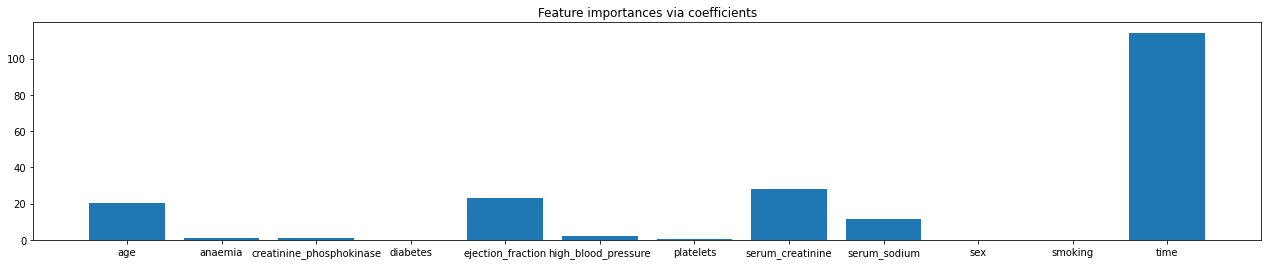

In [61]:
from numpy import set_printoptions
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

k_best = SelectKBest(score_func=f_classif, k=5)
k_best_fit = k_best.fit(predictors_df, labels_df.values.flatten())

set_printoptions(precision=3)
features = k_best_fit.transform(predictors_df)

plt.figure(figsize=(22,4))
plt.bar(height=k_best_fit.scores_, x=predictors)
plt.title("Feature importances via coefficients")
plt.show()

In [62]:
df_kbest = pd.DataFrame(data=[k_best_fit.scores_], columns=[predictors])
df_kbest_T = df_kbest.T
df_kbest_T_tmp = df_kbest_T.rename(columns={0:'SelectKBest'})
df_kbest_T_sorted=df_kbest_T_tmp.sort_values(by=['SelectKBest'], ascending=False)
df_kbest_T_sorted

,SelectKBest
time,114.181264
serum_creatinine,28.158492
ejection_fraction,23.094063
age,20.410478
serum_sodium,11.765331
high_blood_pressure,1.881937
anaemia,1.310096
creatinine_phosphokinase,1.173259
platelets,0.718880
smoking,0.047333


### Feature Selection via SelectFromModel

This is a Meta-transformer for selecting features based on importance weights.

In [63]:
from sklearn.feature_selection import SelectFromModel
#Selecting the Best important features according to Logistic Regression using SelectFromModel

feat_selector = SelectFromModel(estimator=LogisticRegression())
sel_mdl_fit = feat_selector.fit(predictors_df, labels_df.values.flatten())

In [64]:
df_sel_mdl = pd.DataFrame(data=[feat_selector.get_support()], columns=[predictors])
df_sel_mdl_T = df_sel_mdl.T
df_sel_mdl_T_tmp = df_sel_mdl_T.rename(columns={0:'SelectFromModel'})
df_sel_mdl_T_tmp.loc[df_sel_mdl_T_tmp.SelectFromModel == True, "SelectFromModel"] = 1
df_sel_mdl_T_tmp.loc[df_sel_mdl_T_tmp.SelectFromModel == False, "SelectFromModel"] = 0
df_sel_mdl_T_sorted=df_sel_mdl_T_tmp.sort_values(by=['SelectFromModel'], ascending=False)
df_sel_mdl_T_sorted

,SelectFromModel
age,1
ejection_fraction,1
serum_creatinine,1
time,1
anaemia,0
creatinine_phosphokinase,0
diabetes,0
high_blood_pressure,0
platelets,0
serum_sodium,0


### Recursive Feature Elimination

The Recursive Feature Elimination (or RFE) works by recursively and remove attributes and then builds on those attributes that remain. It then evaluates the model to understand the importance of the removed feature.

In [65]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

# feature extraction
lg_estimator = LogisticRegression(solver='lbfgs')
rfe_eliminator = RFE(lg_estimator, 4)
rfe_fit = rfe_eliminator.fit(predictors_df, labels_df.values.flatten())
print("Num Features: %d" % rfe_fit.n_features_)
print("Selected Features: %s" % rfe_fit.support_)
print("Feature Ranking: %s" % rfe_fit.ranking_)

Num Features: 4
Selected Features: [ True False False False  True False False  True False False False  True]
Feature Ranking: [1 9 4 6 1 7 5 1 2 3 8 1]


In [66]:
df_rfe = pd.DataFrame(data=[rfe_fit.ranking_], columns=[predictors])
df_rfe_T = df_rfe.T
df_rfe_T_tmp = df_rfe_T.rename(columns={0:'RFE'})

df_rfe_T_sorted=df_rfe_T_tmp.sort_values(by=['RFE'], ascending=True)
df_rfe_T_sorted

,RFE
age,1
ejection_fraction,1
serum_creatinine,1
time,1
serum_sodium,2
sex,3
creatinine_phosphokinase,4
platelets,5
diabetes,6
high_blood_pressure,7


### Based on the above Feature Selection rankings the 4 top predictors are 'time', 'ejection_fraction', 'serum_creatinine', and 'age'

![title](https://github.com/pam1202g/SIT720_A5/raw/main/feat_select_table.png)

# Experiments

<h3 style="line-height:1.2;"><u>Approach 1</u><br>
Implemented LogitBoost that uses loss function from Logistic Regression classification algorithm into the Boosting framework. Adaptive Boosting algorithm uses 'Exponential loss' function whereas LogitBoost uses the 'Logistic loss' function.<br>
<br>The logistic loss deals with the misclassified examples in a more measured way than Adaboost's exponential loss function. As a result the LogitBoost framework is less sensitive to outliers and noise.<br>
<br>I am trying to leverage the power of Boosting framework to minimizing the errors and using AdaBoost algorithm as a particular technique for minimizing the logistic loss function</h3>

<h3 style="line-height:1.2;"><u>Approach 2</u>
Implemented Stacking using heterogeneous strong learners and combining the predictions using a meta learner which is actually a second level estimator.</h3><br>
    
    <p>The first level base learners are diverse and strong. I am using</p>
    <p>The second level estimator training on the outputs(predictions) of the base estimators.</p>


In [67]:
cardiac_df = df_all[["age", "ejection_fraction", "serum_creatinine", "time", "death_event"]]
cardiac_df.head()

,age,ejection_fraction,serum_creatinine,time,death_event
0,75,20,1.9,4,1
1,55,38,1.1,6,1
2,65,20,1.3,7,1
3,50,20,1.9,7,1
4,65,20,2.7,8,1


# Approach 1 - Final Model

## Logitboost : A Boosting Ensemble Framework of DecisionTreeRegressors with logistic loss as the loss function [1]

I am implementing LogiBoost model which is a boosting framework that uses <b>logistic loss</b> function instead of the <b>exponential loss</b> function used by AdaBoost. The LogitBoost algorithm performs the following steps within each iteration. Let probability $P_i$ = $P(y_i=1 | x_i)$ :
1. Depending on the prediction probability difference from the true label, compute the working response   
\\[ resp_i = \frac{y_i-P_i}{P_i (1-P_i)} \\]

2. Next, update the weights, $weights_i=P_i (1-P_i)$
3. Now train a weak regression stump $h_t (x)$ on the weighted examples $(x_i,resp_i,weights_i)$
4. Then update the ensemble, $F_{t+1}(x) = F_t(x) + h_t(x)$
5. Finally, update the probabilities
\\[ P_i = \frac{1}{1+e^{-F_{t+1}(x) }}. \\]
    


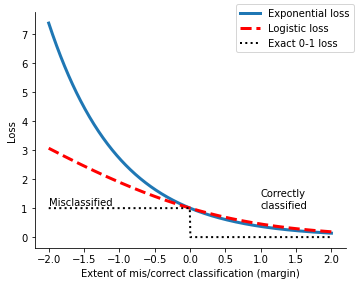

In [68]:
%matplotlib inline

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 4))

x = np.linspace(-2.0, 2.0, num=500)
ax.plot(x, np.exp(-x), linewidth=3, marker=None)
ax.plot(x, np.log(1 + np.exp(-x)) / np.log(2), linewidth=3, linestyle='--', c='r', marker=None)
ax.plot(x, (-x >= 0).astype(float), linewidth=2, linestyle=':', c='k', marker=None)
ax.text(-2, 1.1, 'Misclassified')
ax.text(1, 1, 'Correctly\nclassified')
ax.set_xlabel('Extent of mis/correct classification (margin)')
ax.set_ylabel('Loss')
fig.legend(['Exponential loss', 'Logistic loss', 'Exact 0-1 loss'])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

fig.tight_layout()

### LogitBoost fit function

#### The DecisionTreeRegressors are predicting on the test data set. The result is a continuos values. I pass these to the expit function. This is called the logistic sigmoid function. [2]

In [69]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import accuracy_score
from scipy.special import expit

def fit_lb_model(features, target, n_estimators):
    estimators = [] 
    num_records = features.shape[0]
    # Initializes weights
    weights = np.ones((num_records, )) / num_records 
    prob = np.full((num_records, ), 0.5)                   
                                    
    for idx in range(n_estimators):
        # compute responses
        resp = (target - prob) / (prob * (1 - prob))
        # compute new weights
        weights = prob * (1 - prob)

        dtree_reg = DecisionTreeRegressor(max_depth = 1, random_state=50)
        dtree_reg.fit(features, resp, sample_weight = weights)                
        estimators.append(dtree_reg)
        
        if idx == 0:
            margin = np.array([dtree_reg.predict(features) for dtree_reg in estimators]).reshape(-1, )
        else:
            margin = np.sum(np.array([dtree_reg.predict(features) for dtree_reg in estimators]), axis=0)

        prob = expit(margin)

    return estimators

### LogitBoost predict function

LogitBoost requires training labels to be in 0/1 form which is different from AdaBoost requires them to be in -1/1 form. The Predict function returns 0/1

In [70]:
def predict_lb(feat_test, estimators):
    prediction = np.zeros((feat_test.shape[0], ))

    for dtree_reg in estimators:
        prediction += dtree_reg.predict(feat_test)

    transformed_preds = (np.sign(prediction) + 1) / 2

    return transformed_preds

### LogitBoost Model Training 

In [71]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import accuracy_score
from scipy.special import expit


def train_logit_boost(target_index, n_estimators, c_df):
    metric_records = []
    reproducible_counter = 200
    record_count = c_df.shape[0]
      
    for i in range(number_of_executions):
        c_df_rnd = c_df.sample(n=record_count, random_state=reproducible_counter)
        reproducible_counter -= 1
        
        cardiac_np = c_df.to_numpy() 
        X = cardiac_np[:, 0:target_index]
        y = cardiac_np[:, target_index:]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=50, stratify=y)

        n_samples, n_features = X.shape
        p = np.full((n_samples,), 0.5)
        estimators = []
        
        estimators = fit_lb_model(X_train, y_train.flatten(), n_estimators)
        y_pred = predict_lb(X_test, estimators)

        metric = model_metrics(y_test, y_pred, y_pred)
        metric_records.append(metric)
        
    model_metrics_df = pd.DataFrame(columns=["MCC","F1 Score","Accuracy","TP Rate","TN Rate","PR AUC","ROC AUC"], 
                                    data=metric_records)
    return model_metrics_df

In [72]:
trg_idx = get_index(cardiac_df, "death_event")

In [73]:
lgboost_metrics_df = train_logit_boost(trg_idx, 60, cardiac_df)

print("Reporting the metrics obtained after the Logit Boost model training")
print(lgboost_metrics_df["MCC"].mean(), lgboost_metrics_df["F1 Score"].mean(), lgboost_metrics_df["Accuracy"].mean(), 
      lgboost_metrics_df["TP Rate"].mean(),lgboost_metrics_df["TN Rate"].mean(), lgboost_metrics_df["PR AUC"].mean(), 
      lgboost_metrics_df["ROC AUC"].mean())

lgb_val = [lgboost_metrics_df["MCC"].mean(), lgboost_metrics_df["F1 Score"].mean(), lgboost_metrics_df["Accuracy"].mean(), 
      lgboost_metrics_df["TP Rate"].mean(),lgboost_metrics_df["TN Rate"].mean(), lgboost_metrics_df["PR AUC"].mean(), 
      lgboost_metrics_df["ROC AUC"].mean()]

Reporting the metrics obtained after the Logit Boost model training
0.723785254830659 0.7999999999999985 0.8833333333333349 0.7368421052631585 0.9512195121951234 0.7280701754385969 0.84403080872914


In [74]:
lgb_report_df = pd.DataFrame(columns=["MCC","F1 Score","Accuracy","TP Rate","TN Rate","PR AUC","ROC AUC"], 
                                    data=[lgb_val])

In [75]:
lgb_report_df.head()

,MCC,F1 Score,Accuracy,TP Rate,TN Rate,PR AUC,ROC AUC
0,0.723785,0.8,0.883333,0.736842,0.95122,0.72807,0.844031


# Approach 2  - Experimental Model

## Stacking using heterogeneous strong learners and combining the predictions using a meta learner

In [76]:
from sklearn.ensemble import BaggingClassifier
import xgboost as xgb
from sklearn.neural_network import MLPClassifier

base_estimator_1 = DecisionTreeClassifier(max_depth=5, random_state=50)
bagging_classifier_1 = BaggingClassifier(base_estimator=base_estimator_1, bootstrap=True, n_estimators=60, 
                            max_samples=100, oob_score=True, random_state=50)

xgb_clf_1 = xgb.XGBClassifier(random_state=50, 
                            max_depth=2, 
                            learning_rate=1,
                            use_label_encoder=False, eval_metric='logloss')

mlp_clf = MLPClassifier(max_iter=2000, hidden_layer_sizes=100, random_state=50)

estimators = [('bg', bagging_classifier_1),
              ('xgb', xgb_clf_1),
              ('mlp', mlp_clf)] 

In [77]:
def fit_stacking_estimators(estimators, X, y):
    for model, estimator in estimators:
        estimator.fit(X, y)
    return estimators

In [78]:
def predict_individual_estimator(X, estimators, proba=False):
    n_estimators = len(estimators)
    n_samples = X.shape[0] 
    np.random.seed(100)

    y = np.zeros((n_samples, n_estimators))
    for i, (model, estimator) in enumerate(estimators):
        if proba:
            y[:, i] = estimator.predict_proba(X)[:, 1]  
        else:
            y[:, i] = estimator.predict(X)              
    return y

In [79]:
def fit_stacking(level1_estimators, level2_estimator, X, y, use_probabilities=False):

    fit_stacking_estimators(level1_estimators, X, y)
    X_meta = predict_individual_estimator(X, estimators=level1_estimators, proba=use_probabilities)
    
    level2_estimator.fit(X_meta, y)

    final_model = {'level-1': level1_estimators, 
                   'level-2': level2_estimator, 
                   'use-proba': use_probabilities}
    
    return final_model

In [80]:
from sklearn.model_selection import StratifiedKFold

def fit_stacking_with_CrossValidation(level1_estimators, level2_estimator, 
                                      X, y, n_folds=5, use_probabilities=False):
    n_samples = X.shape[0]
    n_estimators = len(level1_estimators)
    np.random.seed(100)

    X_meta = np.zeros((n_samples, n_estimators))

    splitter = StratifiedKFold(n_splits=n_folds, shuffle=True)
    for trn, val in splitter.split(X, y):
        level1_estimators = fit_stacking_estimators(level1_estimators, X[trn, :], y[trn])
        X_meta[val, :] = predict_individual_estimator(X[val, :],
                                           estimators=level1_estimators,  
                                           proba=use_probabilities)

    level2_estimator.fit(X_meta, y) 

    level1_estimators = fit_stacking_estimators(level1_estimators, X, y)

    final_model = {'level-1': level1_estimators, 
                   'level-2': level2_estimator, 
                   'use-proba': use_probabilities}

    return final_model

In [81]:
def predict_stacking(X, stacked_model):
    level1_estimators = stacked_model['level-1']
    use_probabilities = stacked_model['use-proba']

    X_meta = predict_individual_estimator(X, estimators=level1_estimators, proba=use_probabilities)

    level2_estimator = stacked_model['level-2']
    y = level2_estimator.predict(X_meta)
    
    return y

In [82]:
from sklearn.linear_model import SGDClassifier

In [83]:
def run_stacking(target_index, c_df):
    metric_records = []
    reproducible_counter = 200
    record_count = c_df.shape[0]

    for i in range(100):
        cardiac_df_rnd = c_df.sample(n=record_count, random_state=reproducible_counter)
        reproducible_counter -= 1

        X_train, X_test = train_test_feature_split(cardiac_df_rnd, target_index)
        y_train, y_test = train_test_label_split(cardiac_df_rnd, target_index)
        
        scaler = preproc.StandardScaler()
        scaler.fit(X_train)
        X_train = scaler.transform(X_train)
        
        X_test = scaler.transform(X_test)
        meta_estimator = SGDClassifier(loss="log", penalty=None, class_weight="balanced", 
                                       average=True, random_state=50)    
        stacking_model = fit_stacking_with_CrossValidation(estimators, meta_estimator, 
                                                           X_train, y_train.values.ravel(), 
                                                           use_probabilities=True)
        
        y_pred = predict_stacking(X_test, stacking_model)
        metric = model_metrics(y_test, y_pred, y_pred)
        metric_records.append(metric)
        
    model_metrics_df = pd.DataFrame(columns=["MCC","F1 Score","Accuracy","TP Rate","TN Rate","PR AUC","ROC AUC"], 
                                    data=metric_records)
    return model_metrics_df

In [84]:
st_metrics_df = run_stacking(trg_idx, cardiac_df)

In [85]:
print(st_metrics_df["MCC"].mean(), st_metrics_df["F1 Score"].mean(), st_metrics_df["Accuracy"].mean(), 
      st_metrics_df["TP Rate"].mean(), st_metrics_df["TN Rate"].mean(), st_metrics_df["PR AUC"].mean(), 
      st_metrics_df["ROC AUC"].mean())

st_val = [st_metrics_df["MCC"].mean(), st_metrics_df["F1 Score"].mean(), st_metrics_df["Accuracy"].mean(), 
      st_metrics_df["TP Rate"].mean(),st_metrics_df["TN Rate"].mean(), st_metrics_df["PR AUC"].mean(), 
      st_metrics_df["ROC AUC"].mean()]

0.6191072033154317 0.7421256608946528 0.8209999999999996 0.8261800732458288 0.818666434048906 0.6210064790314401 0.8224232536473676


In [86]:
st_report_df = pd.DataFrame(columns=["MCC","F1 Score","Accuracy","TP Rate","TN Rate","PR AUC","ROC AUC"], 
                                    data=[st_val])

In [87]:
st_report_df.head()

,MCC,F1 Score,Accuracy,TP Rate,TN Rate,PR AUC,ROC AUC
0,0.619107,0.742126,0.821,0.82618,0.818666,0.621006,0.822423


## Based on these two experiments I nominate the first model that is the LogitBoost model as my proposed solution because it returns a better MCC metric.

## References

[1](References: Jerome Friedman, Trevor Hastie, and Robert Tibshirani. "Additive Logistic Regression: A Statistical View of Boosting". The Annals of Statistics. Volume 28, Number 2 (2000), page. 337–374. JSTOR. Project Euclid.)
https://projecteuclid.org/journals/annals-of-statistics/volume-28/issue-2/Additive-logistic-regression--a-statistical-view-of-boosting-With/10.1214/aos/1016218223.full

[2] https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.expit.html